In [29]:
import re
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import random
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
import xgboost as xgb
import operator
from scipy.stats import uniform as sp_rand
from scipy.stats import randint as sp_randint
import scipy.stats as st
from scipy.stats.mstats import mode
from matplotlib import pyplot as plt
import seaborn as sns
import time
import math
import datetime
import random
from yellowbrick.features import ParallelCoordinates, Rank2D, JointPlotVisualizer
from yellowbrick.regressor import ResidualsPlot, AlphaSelection, PredictionError

%matplotlib inline


C:\Users\jerome\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [17]:
train = pd.read_csv('../dsi_capstone/assets/train.csv')
test = pd.read_csv('../dsi_capstone/assets/test.csv')
event_type = pd.read_csv('../dsi_capstone/assets/event_type_fixed.csv')
log_feature = pd.read_csv('../dsi_capstone/assets/log_feature.csv')
resource_type = pd.read_csv('../dsi_capstone/assets/resource_type.csv')
severity_type = pd.read_csv('../dsi_capstone/assets/severity_type.csv')
sample_submission = pd.read_csv('../dsi_capstone/assets/sample_submission.csv')
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [18]:
# The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files. 
# Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

# ### Step 2: Data Preprocessing

# In[2]:

num_train_data = train.shape[0]
enc = OneHotEncoder(sparse=False)
Y = enc.fit_transform(train[['fault_severity']].as_matrix()) # Y contains targets

train_test = train.drop(['fault_severity'],axis=1)
train_test = train_test.append(test,ignore_index=True)
train_test['location'] = train_test.location.map(lambda x: re.findall(r'\d+',x)[0])

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [19]:
train_test.head()

,id,location
0,14121,118
1,9320,91
2,14394,152
3,8218,931
4,14804,120


In [20]:
event_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34083 entries, 0 to 34082
Data columns (total 2 columns):
id            34082 non-null float64
event_type    34083 non-null object
dtypes: float64(1), object(1)
memory usage: 532.6+ KB


In [21]:
resource_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21076 entries, 0 to 21075
Data columns (total 2 columns):
id               21076 non-null int64
resource_type    21076 non-null object
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [22]:
data = event_type.merge(resource_type, on = 'id', how = 'inner')
data = data.merge(severity_type, on = 'id', how = 'inner')
data = data.merge(log_feature, on = 'id', how = 'inner')
data['severity_type'] = data.severity_type.map(lambda x: re.findall(r'\d+',x)[0])
data['log_feature'] = data.log_feature.map(lambda x: re.findall(r'\d+',x)[0])
data['event_type'] = data.event_type.map(lambda x: re.findall(r'\d+',x)[0])
data['resource_type'] = data.resource_type.map(lambda x: re.findall(r'\d+',x)[0])


In [23]:
all_data = pd.merge(train_test, data, on='id', how='inner')
all_data.head(10)

,id,location,event_type,resource_type,severity_type,log_feature,volume
0,14121,118,34,2,2,312,19
1,14121,118,34,2,2,232,19
2,14121,118,35,2,2,312,19
3,14121,118,35,2,2,232,19
4,9320,91,34,2,2,315,200
5,9320,91,34,2,2,235,116
6,9320,91,35,2,2,315,200
7,9320,91,35,2,2,235,116
8,9320,91,34,2,2,315,200
9,9320,91,34,2,2,235,116


In [25]:
# Different types of features are extracted from log files and other sources: event_type.csv, log_feature.csv, resource_type.csv, severity_type.csv. All above features are categorical except for "volume".
# Note: “severity_type” is a feature extracted from the log files (in severity_type.csv). Often this is a severity type of a warning message coming from the log. "severity_type" is categorical. It does not have an ordering. 

# ### Step 3: Feature Extraction

# In[5]:

feature_name = ['location', 'event_type', 'resource_type', 'severity_type', 'log_feature']
enc = OneHotEncoder(n_values=np.array([1127, 55, 11, 6, 387]), sparse=False)
features = all_data['id']
features = pd.concat([features,         pd.DataFrame(data=enc.fit_transform(all_data[feature_name].as_matrix()))], axis=1)
features = features.astype(int)
features['vol'] = all_data['volume']
feature_name.append('volume')
features = features.groupby(['id'],sort=False, as_index=False).sum()
features.head() 

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


,id,0,1,2,3,4,5,6,7,8,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,vol
0,14121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,76
1,9320,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1264
2,14394,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,8218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,88
4,14804,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,96


In [26]:
# Above table shows 1587 exctracted features. We might not need all of them for further progress. We try to estimate the importance of each feature in the next step.

# ### Step 4: Feature Selection
# We use cross-correlation analysis to see how features and targets are correlated. 

# In[6]:

features_norm = (features - features.mean()) / (features.max() - features.min())
cross_corr = features_norm[:num_train_data].drop(['id'],axis=1)
cross_corr['Y0'] = Y[:,0]
cross_corr['Y1'] = Y[:,1]
cross_corr['Y2'] = Y[:,2]
cross_corr = cross_corr.corr().fillna(0)
cross_corr = cross_corr[['Y0', 'Y1', 'Y2']].drop(['Y0', 'Y1', 'Y2'])
cross_corr.transpose()

,0,1,2,3,4,5,6,7,8,9,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,vol
Y0,0.0,-0.013146,-0.023841,0.011507,-0.022345,0.008577,-0.015799,-0.004467,0.000210,0.036367,...,-0.019253,-1.762242e-15,-0.015799,-1.762242e-15,-1.762242e-15,-0.020538,0.008577,-1.762242e-15,-1.762242e-15,0.025226
Y1,0.0,0.015727,0.031237,-0.009101,0.028252,-0.006783,0.019976,-0.015486,0.005416,-0.028763,...,0.007540,-3.890519e-16,-0.006783,-3.890519e-16,-3.890519e-16,-0.008818,-0.006783,-3.890519e-16,-3.890519e-16,-0.097786
Y2,0.0,-0.001892,-0.007398,-0.005159,-0.005438,-0.003845,-0.003845,0.029784,-0.008248,-0.016303,...,0.019859,-4.430143e-16,0.035243,-4.430143e-16,-4.430143e-16,0.045814,-0.003845,-4.430143e-16,-4.430143e-16,0.102388


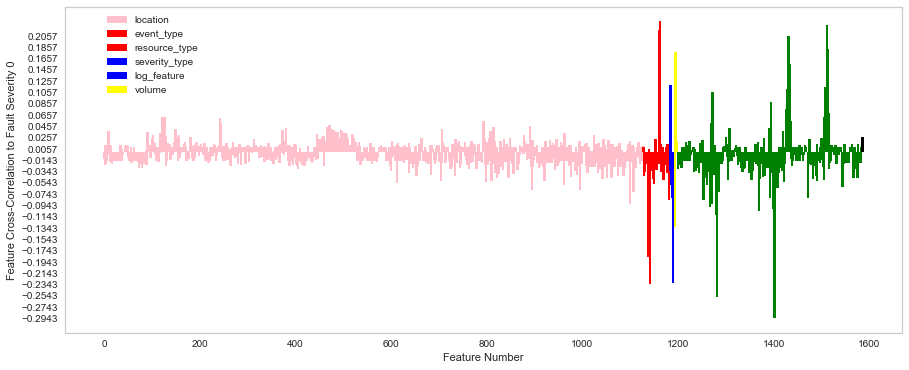

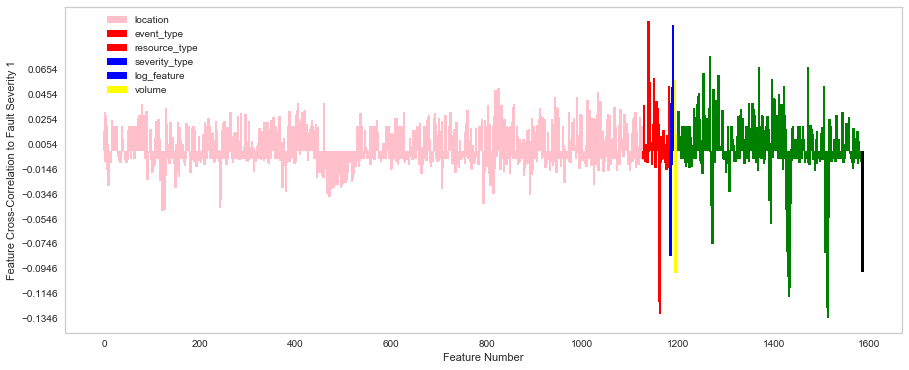

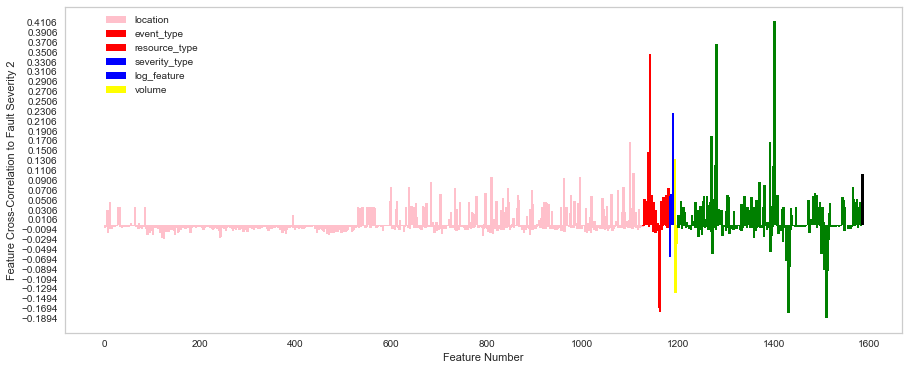

In [28]:
clr = ['pink', 'red', 'blue', 'yellow', 'green', 'black']

for idx_corr in range(3):
    Y_corr = cross_corr.iloc[:,idx_corr]
    plt.figure(figsize=(15,6))
    for idx, n_featuer in enumerate(enc.n_values):
        xx = np.arange(enc.feature_indices_[idx], enc.feature_indices_[idx+1])
        yy = Y_corr[xx]
        plt.bar(xx, yy, width=5, color=clr[idx])
        plt.bar(1586,Y_corr[1586], width=5, color=clr[idx+1])
        plt.xlabel('Feature Number')
        plt.ylabel('Feature Cross-Correlation to Fault Severity '+str(idx_corr))
        plt.yticks(np.arange(min(yy), max(yy), 0.02))
        plt.grid(which='both', axis='both') 
        plt.legend(feature_name, bbox_to_anchor=(0.17, 1))    


In [30]:
cct = 0.03 # Cross-Correlation Thereshold

In [31]:
for idx in range(3):
    X = features_norm[:num_train_data].drop(['id'],axis=1).as_matrix()
    X = X[:,np.transpose(np.nonzero(np.absolute(cross_corr.iloc[:,idx])>cct))][:,:,0]
    gb = GradientBoostingClassifier()
    clf = GridSearchCV(gb, {'max_depth': [2, 3, 4], 
                            'n_estimators': [100, 150], 
                            'learning_rate': [0.5], 
                            'subsample': [1], 
                            'max_leaf_nodes': [3]}, 
                       verbose=1, n_jobs=2, cv=3, scoring='log_loss')
    clf.fit(X, Y[:,idx])
    joblib.dump(clf, '../dsi_capstone/clfgb'+str(idx)+'.pkl')


C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:   26.0s finished
C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:   13.7s finished
C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:   24.3s finished


In [33]:
# ### Step 6: Prediction


Y_pred = []
log_loss = []
for idx in range(3):
    clf = joblib.load('../dsi_capstone/clfgb'+str(idx)+'.pkl') 
    X_t = features_norm[num_train_data:].drop(['id'],axis=1).as_matrix()
    X_t = X_t[:,np.transpose(np.nonzero(np.absolute(cross_corr.iloc[:,idx])>cct))][:,:,0]
    Y_pred.append(clf.predict_proba(X_t))
    log_loss.append(-clf.best_score_)
    print('Number of features for model ' + str(idx) + ' : ' + str(X_t.shape[1]))
    
print('Model log-loss: ' + str(np.mean(log_loss)))
    

prediction = pd.DataFrame({'id': features[num_train_data:].id,
                           'predict_0': Y_pred[0][:,1], 
                           'predict_1': Y_pred[1][:,1], 
                           'predict_2': Y_pred[2][:,1]})

prediction.to_csv('../dsi_capstone/Telestra_gbclf.csv',index=False)
prediction.head()


C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Number of features for model 0 : 187
Number of features for model 1 : 125
Number of features for model 2 : 211
Model log-loss: 0.37725691581048193


,id,predict_0,predict_1,predict_2
7381,11066,0.816986,0.033665,0.004941
7382,18000,0.285890,0.216120,0.687940
7383,16964,0.913222,0.036309,0.003859
7384,4795,0.825145,0.090503,0.008987
7385,3392,0.298349,0.612510,0.234985
